In [1]:
from Functions import *
import winsound

# Preliminary

In [2]:
FOV1 = 5e-3; N1 = 512
FOV2 = 5e-3; N2 = 10240

In [3]:
def define_Telescope(E0, m1_p=185.0, m1_q=-58.0, m2_p=None, m2_q=None):
    '''
    defines the Telescope optics
    E0: photon energy [eV]
    m1_p: mirror 1 source distance [m]
    m1_q: mirror 1 image distance [m], negative value indicates diverging mirror
    m2_p: mirror 2 source distance [m]
    m2_q: mirror 2 image distance [m]

    returns optics
    '''

    z_s = 650
    
    ## Telescope
    m1 = optics.CurvedMirror('M1', p=m1_p, q=m1_q, length=1, z=m1_p+z_s, alpha=2.65e-3)
    if m2_p is None:
        m2_p = 300 - m1_p - m1_q
    if m2_q is None:
        m2_q = 1e5    # fix the image distance to be 100km so the output is almost parallel
    m2 = optics.CurvedMirror('M2', p=m2_p, q=m2_q, length=1, z=300+z_s, alpha=2.65e-3, orientation=2)
    
    im_after_T1 = optics.PPM('im_after_T1', z=m1.z+.01, FOV=5e-3, N=512)
    im_after_T2 = optics.PPM('im_after_T2', z=m2.z+.01, FOV=5e-3, N=512)

    Telescope_devices = [m1, im_after_T1, m2, im_after_T2]

    return Telescope_devices

def define_beamline_normal(
    E0, m1_p=185.0, m1_q=-25.6, m2_p=141.6, m2_q=1e5,
    HHLM_type='2DCM', HHLM_offset=20e-3, pair_distance=200e-3,
    slit_width=3e-6, f1=10.0, f2=10.0,
    hkl1 = [1,1,1], alphaAsym1 = 0.0,
    hkl2 = [2,2,0], alphaAsym2 = 0.0,
    hkl3 = [5,5,5], alphaAsym3 = 15.0,
    shapeErrors=[None for i in range(6)],
    l_crystal=[1e-1 for i in range(6)],
    w_crystal = [5e-3 for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=5e-3, N=512)
    
    Telescope_devices = define_Telescope(E0, m1_p=m1_p, m1_q=m1_q, m2_p=m2_p, m2_q=m2_q)
    
    if HHLM_type == '2DCM':
        HHLM_devices = define_HHLM_2DCM(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    elif HHLM_type == 'Zigzag':
        HHLM_devices = define_HHLM_Zigzag(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    
    HRM_devices = define_HRM(E0, f1=f1, f2=f2, slit_width=slit_width,
                            hkl=hkl3, alphaAsym=alphaAsym3,
                            shapeErrors=shapeErrors,
                            l_crystal=l_crystal,
                            w_crystal=w_crystal)
    
    im_output = optics.PPM('im_output', FOV=FOV1,N=N1,z=HRM_devices[-1].z+1.1e-3)
    
    all_devices = [im_input] + Telescope_devices + HHLM_devices + HRM_devices + [im_output]
    
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return all_devices, mono_beamline

### 1. common simulation parameters

In [4]:
##### ''' Beam parameters '''
N = 1024          # number of sampling points
E0 = 9000        # photon energy [eV]

beam_size_factor = 1.0
crystal_size_factor = 1

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 23e-6,
    'sigma_y': 23e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 650
}

##### common simulation parameters
m1_p = 185.0     # mirror 1 source distance

# calculate beam size at mirror 1
wavelength = 1239.84193e-9/E0
Rayleigh_length = np.pi*beam_params['sigma_x']**2/wavelength
beam_width_z = 2.35*beam_params['sigma_x'] * np.sqrt(1+np.square((m1_p)/Rayleigh_length))    # 2 x FWHM

# estimate m2_p geometrically
m2_p = 2.65e-3*beam_size_factor/(2.65e-3*beam_size_factor-beam_width_z)*115
m1_q = 115.0 - m2_p

# m2_p = 167.84807898562158    # optimized 9keV
# m2_p = 154.02912324967807    # optimized 11keV
# m2_p = 310.2877545365738    # optimized 9keV-111-440 50% size
# m2_p = 189.53436487067424    # optimized 9keV-111-440 80% size


print(m1_p, m1_q, m2_p)

f1 = 10.0; f2 = 10.0            # f1: crystal-mirror distance, f2: mirror focal distance

HHLM_type = '2DCM'              # 2DCM or Zigzag
HHLM_offset=20e-3
pair_distance=200e-3
hkl1 = [1,1,1]; alphaAsym1 = 9    # asymmetry angle for the 1st pair of HHLM crystal
hkl2 = [4,4,0]; alphaAsym2 = 38.3   # ````````````````````````2nd pair of HHLM crystal
hkl3 = [4,4,0]; alphaAsym3 = 15.0   # ````````````````````````2nd and 3rd HRM crystal

# list of crystals
crystals = np.array(['HHLM1', 'HHLM2', 'HHLM3', 'HHLM4', 'C1', 'C2']); n_crys = len(crystals)

##### I/O
dir_out = 'beam_size_crystal_size_scan/'; make_dir(dir_out)
dir_plot = dir_out+'{}eV_{}_{}-{}_{}-{}_{}mm/'.format(E0, HHLM_type,
                                          hkl1[0]*100+hkl1[1]*10+hkl1[2], alphaAsym1,
                                          hkl2[0]*100+hkl2[1]*10+hkl2[2], alphaAsym2,
                                          HHLM_offset*1e3); make_dir(dir_plot)
dir_plot += 'beam_size_{}x_crystal_size{}x'.format(beam_size_factor, crystal_size_factor)
print('\nCWD:',dir_plot)

185.0 -52.50294676423022 167.50294676423022
path exists
path exists

CWD: beam_size_crystal_size_scan/9000eV_2DCM_111-9_440-38.3_20.0mm/beam_size_1.0x_crystal_size1x


### 2. calculate crystal dimensions and slit width

In [5]:
%%capture capt

# simulation parameters for the normal condition
slit_width = 1e-1
shapeErrors = [None for i in range(6)]
l_crystal = [1e-1 for i in range(6)]
w_crystal = [5e-3 for i in range(6)]

mono_devices_calc, mono_beamline_calc = define_beamline_normal(E0,
                               m1_p=m1_p, m1_q=m1_q, m2_p=m2_p,
                               HHLM_type=HHLM_type,
                               HHLM_offset=HHLM_offset,
                               pair_distance=pair_distance,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=[None for i in range(6)],
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

b1_calc = beam.Beam(beam_params=beam_params)
b2_calc = mono_beamline_calc.propagate_beamline(b1_calc)

In [6]:
# get crytal properties
beta0s = []; braggs = []; asyms = []; OE_z = []
for device in mono_devices_calc:
    if device.name in crystals:
        beta0s.append(device.beta0)
        braggs.append(np.rad2deg(device.bragg))
        asyms.append(np.rad2deg(device.alphaAsym))
        OE_z.append(device.z)

# calculate beam FWHM after each crystal
wx1, wy1 = mono_beamline_calc.im_after_HHLM1.beam_analysis(mono_beamline_calc.im_after_HHLM1.get_profile_x(), mono_beamline_calc.im_after_HHLM1.get_profile_y())[2:4]
wx2, wy2 = mono_beamline_calc.im_after_HHLM2.beam_analysis(mono_beamline_calc.im_after_HHLM2.get_profile_x(), mono_beamline_calc.im_after_HHLM2.get_profile_y())[2:4]
wx3, wy3 = mono_beamline_calc.im_after_HHLM3.beam_analysis(mono_beamline_calc.im_after_HHLM3.get_profile_x(), mono_beamline_calc.im_after_HHLM3.get_profile_y())[2:4]
wx4, wy4 = mono_beamline_calc.im_after_HHLM4.beam_analysis(mono_beamline_calc.im_after_HHLM4.get_profile_x(), mono_beamline_calc.im_after_HHLM4.get_profile_y())[2:4]
wx5, wy5 = mono_beamline_calc.im_after_C1.beam_analysis(mono_beamline_calc.im_after_C1.get_profile_x(), mono_beamline_calc.im_after_C1.get_profile_y())[2:4]
wx6, wy6 = mono_beamline_calc.im_after_C2.beam_analysis(mono_beamline_calc.im_after_C2.get_profile_x(), mono_beamline_calc.im_after_C2.get_profile_y())[2:4]
beam_size = np.array([wx1, wx2, wx3, wx4, wx5, wx6])    # FWHM

# crystal lengths (long) and widths (short) [m]
l_crystal = np.divide(beam_size*2, np.sin(beta0s))
w_crystal = np.array([wy1, wy2, wy3, wy4, wy5, wy6])*2


print('bragg angle: {}'.format(np.round(braggs,3)))
print('asymmetry: {}'.format(np.round(asyms,3)))
print('beam size: {} mm'.format(np.round(beam_size*1e3, 3)))
print('footprint: {} mm'.format(np.round(l_crystal*1e3/2, 3)))
print('position:  {} m\n'.format(np.round(OE_z, 5)))


# calculate slit width
slit_width = calc_slit_width(wx6*2, b2_calc.lambda0, mono_beamline_calc.mir1.q)
print('calculated slit width: {}um'.format(round(slit_width*1e6,2)))

if slit_width < 3e-6: slit_width = 3e-6
print('actual slit width: {}um\n'.format(round(slit_width*1e6,2)))

bragg angle: [12.696 12.691 45.849 45.847 45.847 45.847]
asymmetry: [ -9.    9.  -38.3  38.3   0.   15. ]
beam size: [ 7.614  1.329 10.06   1.331  1.331  0.781] mm
footprint: [20.601 20.601 10.113 10.113  1.855  1.524] mm
position:  [955.      955.04214 955.24214 955.24154 960.      959.99941] m

calculated slit width: 0.82um
actual slit width: 3.0um



### M2_p optimization (perfect case)

In [7]:
%%capture capt
screen_names = ['im_input','im_after_T1','im_after_T2',
                'im_after_HHLM1','im_after_HHLM2','im_after_HHLM3','im_after_HHLM4',
                'im_after_C1','im_after_C2','im_before_MIR1','im_after_MIR1','im_focus',
                'im_before_MIR2','im_after_MIR2','im_after_C3','im_out','im_output']

# screen_names = ['im_input','im_after_T1','im_after_T2',
#                 'im_after_HHLM1','im_after_HHLM2','im_after_HHLM3','im_after_HHLM4',
#                 'im_after_C1','im_after_C2','im_focus','im_after_C3','im_out']

# perfect case

mono_devices_p, mono_beamline_p = define_beamline_normal(E0,
                           m1_p=m1_p, m1_q=m1_q, m2_p=m2_p,
                           HHLM_type=HHLM_type,
                           HHLM_offset=HHLM_offset,
                           pair_distance=pair_distance,
                           slit_width=slit_width, f1=f1, f2=f2,
                           hkl1=hkl1, alphaAsym1=alphaAsym1,
                           hkl2=hkl2, alphaAsym2=alphaAsym2,
                           hkl3=hkl3, alphaAsym3=alphaAsym3,
                           shapeErrors=[None for i in range(6)],
                           l_crystal=l_crystal*crystal_size_factor,
                           w_crystal=w_crystal)

beam_params['photonEnergy'] = E0
pulse_p = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=40e-3, N=150)
pulse_p.propagate(beamline=mono_beamline_p,screen_names=screen_names)

winsound.Beep(1500, 1000)

In [8]:
''' diagnostics '''
# perfect
c, pulse_duration0 = pulse_p.pulse_duration('im_out')
pulse_tilt0 = pulse_p.pulsefront_tilt('im_out')
spatial_chirp0 = pulse_p.spatial_chirp('im_out')
energy_bandwidth0 = pulse_p.pulse_bandwidth('im_out')
throughput0 = pulse_p.throughput('im_input','im_out')
print('duration {}fs'.format(pulse_duration0))
print('tilt {}fs/um'.format(pulse_tilt0))
print('spatial chirp {}meV/um'.format(spatial_chirp0*1e3))
print('bandwidth {}meV'.format(energy_bandwidth0*1e3))
print('throughput {}%'.format(throughput0*1e2))
# np.savetxt(dir_plot+'diagnostics_perfect.txt',np.array([pulse_duration0, pulse_tilt0, spatial_chirp0*1e3, energy_bandwidth0*1e3]), delimiter=',')


duration 891fs
tilt -0.33878972846508965fs/um
spatial chirp 0.00139960856351007meV/um
bandwidth 2.904487798136387meV
throughput 23.841136703977376%


Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude     3.685     -inf      inf   0.1056     True     None     None
center      0.03886     -inf      inf  0.02165     True     None     None
fraction   1.274e-10        0        1 0.005941     True     None     None
fwhm          3.078     -inf      inf  0.05918    False 2.0000000*sigma     None
height        1.125     -inf      inf   0.0421    False (((1-fraction)*amplitude)/max(1e-15, (sigma*sqrt(pi/log(2))))+(fraction*amplitude)/max(1e-15, (pi*sigma)))     None
sigma         1.539        0      inf  0.02959     True     None     None


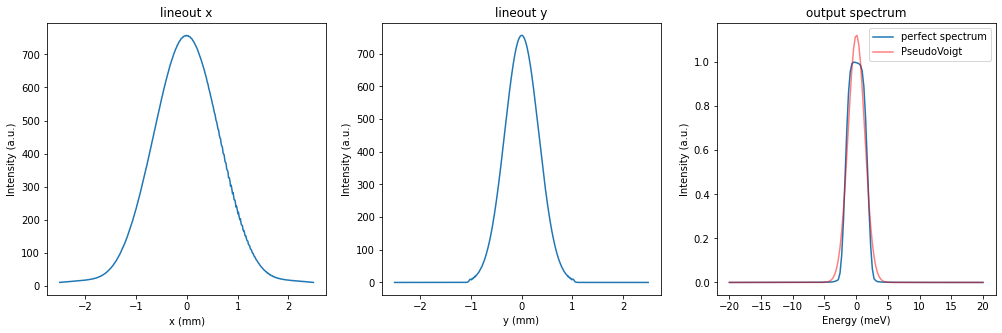

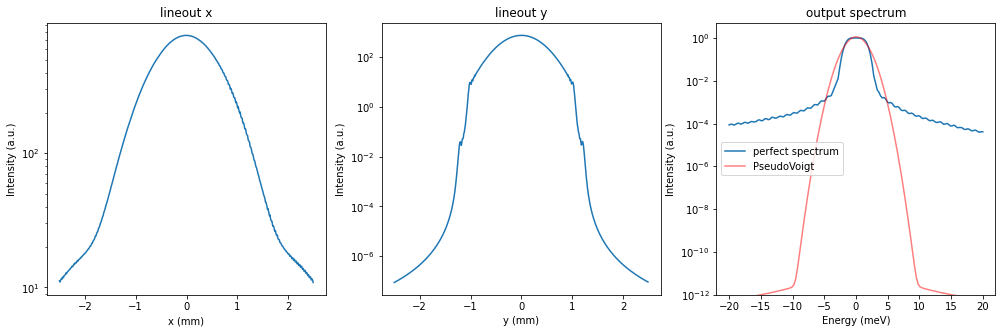

In [9]:
from lmfit.models import PseudoVoigtModel
##### 1D spectrum and lineout
axis_eV, spectral_intensity, _ = get_spectrum(pulse_p, 'im_output', integrated=True)




# PseudoVoigt fit
mod = PseudoVoigtModel()
pars = mod.guess(spectral_intensity, x=axis_eV*1e3)
out = mod.fit(spectral_intensity, pars, x=axis_eV*1e3)

def get_profile(pulse, image_name):
    axis_x = pulse.x[image_name]
    axis_y = pulse.y[image_name]
    profile_2d = np.sum(np.abs(pulse.time_stacks[image_name])**2, axis=-1)
    return axis_x, axis_y, profile_2d

axis_x, axis_y, profile_2d = get_profile(pulse_p, 'im_out')
npts_x, npts_y = profile_2d.shape

yscale = 'linear'
plt.figure(figsize=(17,5))
plt.subplot(1,3,1)
plt.plot(axis_x*1e3, profile_2d[int(npts_y/2)])
plt.xlabel('x (mm)'); plt.ylabel('Intensity (a.u.)'); plt.title('lineout x'); plt.yscale(yscale)

plt.subplot(1,3,2)
plt.plot(axis_y*1e3, profile_2d[:,int(npts_x/2)])
plt.xlabel('y (mm)'); plt.ylabel('Intensity (a.u.)'); plt.title('lineout y'); plt.yscale(yscale)

plt.subplot(1,3,3)
plt.plot(axis_eV*1e3, spectral_intensity, label='perfect spectrum')
plt.plot(axis_eV*1e3, out.best_fit, 'r-', alpha=0.5, label='PseudoVoigt')

plt.legend(); plt.xlabel('Energy (meV)'); plt.ylabel('Intensity (a.u.)'); plt.yscale(yscale)
plt.title('output spectrum')

plt.savefig(dir_plot+'_spectrum_perf_linear.png')

yscale = 'log'
plt.figure(figsize=(17,5))
plt.subplot(1,3,1)
plt.plot(axis_x*1e3, profile_2d[int(npts_y/2)])
plt.xlabel('x (mm)'); plt.ylabel('Intensity (a.u.)'); plt.title('lineout x'); plt.yscale(yscale)

plt.subplot(1,3,2)
plt.plot(axis_y*1e3, profile_2d[:,int(npts_x/2)])
plt.xlabel('y (mm)'); plt.ylabel('Intensity (a.u.)'); plt.title('lineout y'); plt.yscale(yscale)

plt.subplot(1,3,3)
plt.plot(axis_eV*1e3, spectral_intensity, label='perfect spectrum')
plt.plot(axis_eV*1e3, out.best_fit, 'r-', alpha=0.5, label='PseudoVoigt')

plt.ylim([1e-12, 5])

plt.legend(); plt.xlabel('Energy (meV)'); plt.ylabel('Intensity (a.u.)'); plt.yscale(yscale)
plt.title('output spectrum')

plt.savefig(dir_plot+'_spectrum_perf_log.png')

### fit result
out.params.pretty_print()


In [10]:
import winsound
winsound.Beep(1500, 3000)

In [11]:
l_crystal*1e3

array([41.20166419, 41.20103244, 20.22530672, 20.22528515,  3.71081854,
        3.04768403])